<a href="https://colab.research.google.com/github/Kaguya2906/Anomaly_Detection_Weekly_Project/blob/main/08.%20UnderSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## What is imbalanced data?

The definition of imbalanced data is straightforward. A dataset is imbalanced if at least one of the classes constitutes only a very small minority. Imbalanced data prevail in banking, insurance, engineering, and many other fields. It is common in fraud detection that the imbalance is on the order of 100 to 1.

## What are the remedies?
Broadly speaking there are three major approaches to handling imbalanced data: data sampling, algorithm modifications, and cost-sensitive learning. In 08 and 09, we'll include the use of the sampling methods(OverSampling, UnderSampling)

# Libraries, Dataset

In [ ]:
pip install h2o

In [ ]:
import pandas as pd
from imblearn.under_sampling import (RandomUnderSampler,
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)

In [ ]:
df = pd.read_csv("MortgageDefault_Cleaned.csv")

# Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['loan_default'])
y = df['loan_default']

# Splitting train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('Original dataset shape {}'.format(Counter(y)))
print('Training dataset shape {}'.format(Counter(y_train)))

Original dataset shape Counter({0.0: 64512, 1.0: 15488})
Training dataset shape Counter({0.0: 43242, 1.0: 10358})


# ROC_AUC Func

In [ ]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual['loan_default'],y_pred['p1'])
    roc_auc = auc(fpr,tpr)

    # Precision-Recall
    average_precision = average_precision_score(y_actual['loan_default'],y_pred['p1'])

    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual['loan_default'],y_pred['p1'])
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

# Using undersampling techniques:

# (A)Random under-sampling for the majority class

A simple under-sampling technique is to under-sample the majority class randomly and uniformly. This can potentially lead to the loss of information. But if the examples of the majority class are near to others, this method might yield good results.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from h2o.estimators.random_forest import H2ORandomForestEstimator
import h2o
h2o.init()

sampler = RandomUnderSampler(sampling_strategy=0.7)
X_train, y_train = sampler.fit_resample(X_train, y_train)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Convert to h2o frame
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

train_hex[target] = train_hex[target].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_63kftp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.155 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
#Build and train the model
RF_under = H2ORandomForestEstimator(
    ntrees = 500,
    max_depth = 10,
    min_rows = 100,
    nfolds = 10,
    seed = 1234,
    balance_classes = False
)

RF_under.train(x = predictors,
              y = target,
              training_frame = train_hex)

drf Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [TD028, TD027, TD026, TD025, CR012]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1689965284111_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    500                500                         639381                 10           10           10            79            109           96.774

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.22223525877136985
RMSE: 0.47141834793670245
LogLoss: 0.635191152477029
Mean Per-Class Error: 0.39842759869404937
AUC: 0.6789092762432
AUCPR: 0.5821826307514152
Gini: 0.35781855248639993

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3404584573043235
       0     1      Error    Rate
-----  ----  -----  -------  ----------------
0      4379  8809   0.668    (8809.0/13188.0)
1      1190  8042   0.1289   (1190.0/9232.0)
Total  5569  16851  0.446    (9999.0/22420.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340458     0.616647  274
max f2                       0.255187     0.780406  349
max f0point5                 0.434171     0.56232   174
max accuracy                 0.47775      0.645718  131
max precision                0.68796      1         0
max recall                   0.175411     1         392
max specificity              0.68796      1         0
max absolute_mcc             0.434171     0.255756  174
max min_per_class_accuracy   0.415526     0.627058  193
max mean_per_class_accuracy  0.41641      0.629688  192
max tns                      0.68796      13188     0
max fns                      0.68796      9229      0
max fps                      0.130635     13188     399
max tps                      0.175411     9232      392
max tnr                      0.68796      1         0
max fnr                      0.68796      0.999675  0
max fpr                      0.130635     1         399
max tpr                      0.175411     1         392

Gains/Lift Table: Avg response rate: 41.18 %, avg score: 41.18 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100357                   0.62516            1.87805   1.87805            0.773333         0.644143  0.773333                    0.644143            0.0188475       0.0188475                  87.8047   87.8047            0.0149803
2        0.0200268                   0.60788            1.78886   1.83355            0.736607         0.615544  0.755011                    0.629876            0.0178726       0.0367201                  78.8857   83.3552            0.0283792
3        0.0300178                   0.594244           1.68044   1.78259            0.691964         0.600927  0.734027                    0.62024             0.0167894       0.0535095                  68.0442   78.2591            0.0399366
4        0.0400089                   0.584078           1.60455   1.73813            0.660714         0.588712  0.715719                    0.612367            0.0160312       0.0695407                  60.4551   73.8131            0.050205
5        0.05                        0.574499           1.70212   1.73094            0.700893         0.579305  0.712756                    0.605

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


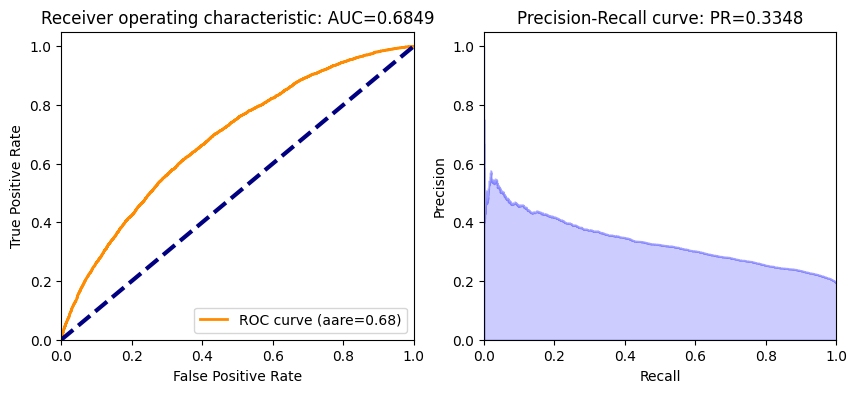

In [ ]:
ROC_AUC(RF_under,test_hex,'loan_default')

# (B)ClusterCentroids

This method undersamples the majority class by replacing a cluster of majority samples This method finds the clusters of the majority class with K-mean algorithms. Then it keeps the cluster centroids of the N clusters as the new majority samples.

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,27 mins 45 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_63kftp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.022 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


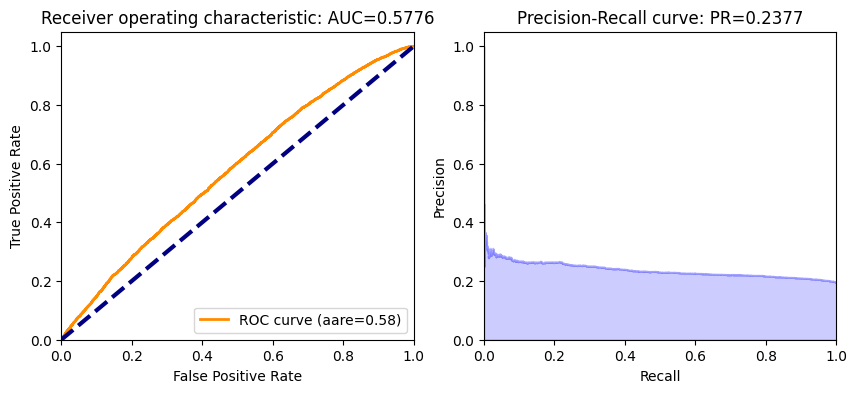

In [ ]:
from imblearn.under_sampling import ClusterCentroids
from h2o.estimators.random_forest import H2ORandomForestEstimator
import h2o
h2o.init()

sampler = ClusterCentroids(sampling_strategy=0.7)
X_train, y_train = sampler.fit_resample(X_train, y_train)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Convert to h2o frame
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

train_hex[target] = train_hex[target].asfactor()

#Build and train the model
RF_under = H2ORandomForestEstimator(
    ntrees = 500,
    max_depth = 10,
    min_rows = 100,
    nfolds = 10,
    seed = 1234,
    balance_classes = False
)

RF_under.train(x = predictors,
              y = target,
              training_frame = train_hex)

ROC_AUC(RF_under,test_hex,'loan_default')

# (C)TomekLinks

In the same manner, Tomek (1976) proposed an effective method that considers samples near the borderline. Given two instances a and b belonging to different classes and are separated by a distance d(a,b), the pair (a, b) is called a Tomek link if there is no instance c such that d(a,c) < d(a,b) or d(b,c) < d(a,b). Instances participating in Tomek links are either borderline or noise so both are removed.

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['loan_default'])
y = df['loan_default']

# Splitting train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('Original dataset shape {}'.format(Counter(y)))
print('Training dataset shape {}'.format(Counter(y_train)))

In [ ]:
from imblearn.under_sampling import TomekLinks
from h2o.estimators.random_forest import H2ORandomForestEstimator
import h2o
h2o.init()

sampler = TomekLinks()
X_train, y_train = sampler.fit_resample(X_train, y_train)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Convert to h2o frame
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

train_hex[target] = train_hex[target].asfactor()

#Build and train the model
RF_under = H2ORandomForestEstimator(
    ntrees = 500,
    max_depth = 10,
    min_rows = 100,
    nfolds = 10,
    seed = 1234,
    balance_classes = False
)

RF_under.train(x = predictors,
              y = target,
              training_frame = train_hex)

ROC_AUC(RF_under,test_hex,'loan_default')

# (D)NeighbourhoodCleaningRule

The neighborhood Cleaning Rule (NCL) deals with the majority and minority samples separately when sampling the data sets. NCL uses ENN to remove the majority of examples. for each instance in the training set, it finds three nearest neighbors. If the instance belongs to the majority class and the classification given by its three nearest neighbors is the opposite of the class of the chosen instance, then the chosen instance is removed. If the chosen instance belongs to the minority class and is misclassified by its three nearest neighbors, then the nearest neighbors that belong to the majority class are removed.

In [ ]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
from h2o.estimators.random_forest import H2ORandomForestEstimator
import h2o
h2o.init()

sampler = NeighbourhoodCleaningRule(sampling_strategy=0.7)
X_train, y_train = sampler.fit_resample(X_train, y_train)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Convert to h2o frame
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

train_hex[target] = train_hex[target].asfactor()

#Build and train the model
RF_under = H2ORandomForestEstimator(
    ntrees = 500,
    max_depth = 10,
    min_rows = 100,
    nfolds = 10,
    seed = 1234,
    balance_classes = False
)

RF_under.train(x = predictors,
              y = target,
              training_frame = train_hex)

ROC_AUC(RF_under,test_hex,'loan_default')

# (E)NearMiss

To attack the issue of potential information loss, the “near neighbor” method and its variations have been proposed. The basic algorithms of the near neighbor family are this: first, the method calculates the distances between all instances of the majority class and the instances of the minority class. Then k instances of the majority class that have the smallest distances to those in the minority class are selected. If there are n instances in the minority class, the “nearest” method will result in k*n instances of the majority class.

In [ ]:
from imblearn.under_sampling import NearMiss
from h2o.estimators.random_forest import H2ORandomForestEstimator
import h2o
h2o.init()

sampler = NearMiss(sampling_strategy=0.7)
X_train, y_train = sampler.fit_resample(X_train, y_train)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Convert to h2o frame
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

train_hex[target] = train_hex[target].asfactor()

#Build and train the model
RF_under = H2ORandomForestEstimator(
    ntrees = 500,
    max_depth = 10,
    min_rows = 100,
    nfolds = 10,
    seed = 1234,
    balance_classes = False
)

RF_under.train(x = predictors,
              y = target,
              training_frame = train_hex)

ROC_AUC(RF_under,test_hex,'loan_default')